IMPORT LIBRARIES AND SET UP

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

# 1. Define Variables
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# 2. Define Paths (Relative to your .ipynb)
base_dir = './ChairToolVision'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir  = os.path.join(base_dir, 'test')

# 3. Setup Data Generators
# Augmentation for Training (To fix dataset size issues)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for Validation/Test (Just rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 4. Load Images
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("\nLoading Validation Data:")
validation_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Check classes
print(f"\nClasses found: {train_generator.class_indices}")

2026-02-03 05:38:09.409959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading Training Data:
Found 636 images belonging to 2 classes.

Loading Validation Data:
Found 84 images belonging to 2 classes.

Classes found: {'chair': 0, 'tool': 1}


Build the Model

In [3]:
 #1. Build the Model
model = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # The Brain
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(384, activation='relu'),
    
    # CHANGED: Dropout from 0.5 to 0.25
    # This relaxes the "strictness" so the Training line can pull up slightly
    tf.keras.layers.Dropout(0.25), 

    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 2. Compile with a Custom Optimizer
# CHANGED: We manually set the learning rate to be lower (0.0005)
# This prevents the "jittery" spikes in your graph.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │    38,535,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,629,185 (147.36 MB)

 Trainable params: 38,629,185 (147.36 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1. Gentle Brakes
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3,       # Wait longer before reducing speed
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

# 2. Relaxed Safety Net
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=8,       # Allow it to run longer to settle the lines
    restore_best_weights=True
)

# 3. Train
print("Starting training for the 'Smooth Graph' look...")
history = model.fit(
    train_generator,
    epochs=30,  # More epochs because we are learning slower
    validation_data=validation_generator,
    verbose=1,
    callbacks=[reduce_lr, early_stop]
)

Starting training for the 'Smooth Graph' look...
Epoch 1/30


2026-02-03 05:39:40.107661: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fcdd8005420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-03 05:39:40.107725: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2026-02-03 05:39:40.181704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-03 05:39:40.648940: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801
2026-02-03 05:39:41.609623: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call

 1/20 ━━━━━━━━━━━━━━━━━━━━ 3:22 11s/step - accuracy: 0.5625 - loss: 0.6920

I0000 00:00:1770068388.033493    1281 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/20 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5641 - loss: 1.2364

2026-02-03 05:40:17.333692: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[28,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-02-03 05:40:17.495729: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[28,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5556 - loss: 1.1496

2026-02-03 05:40:35.821204: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-02-03 05:40:35.981530: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.5330 - loss: 0.9129 - val_accuracy: 0.5119 - val_loss: 0.7341 - learning_rate: 5.0000e-04
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5613 - loss: 0.6836 - val_accuracy: 0.4762 - val_loss: 0.7393 - learning_rate: 5.0000e-04
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6384 - loss: 0.6459 - val_accuracy: 0.4643 - val_loss: 0.8607 - learning_rate: 5.0000e-04
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6450 - loss: 0.6320
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6557 - loss: 0.6335 - val_accuracy: 0.4881 - val_loss: 0.9962 - learning_rate: 5.0000e-04
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6368 - loss: 0.6323 - val_accuracy: 0.5476 - val_loss: 0.9424 - learning_rate: 2.5000e-04
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.6824 - loss: 0.6122 - val_acc

Graph successfully saved at: /home/axel/Jupyter Notebooks/ChairToolVision/accuracy_graph_2.png


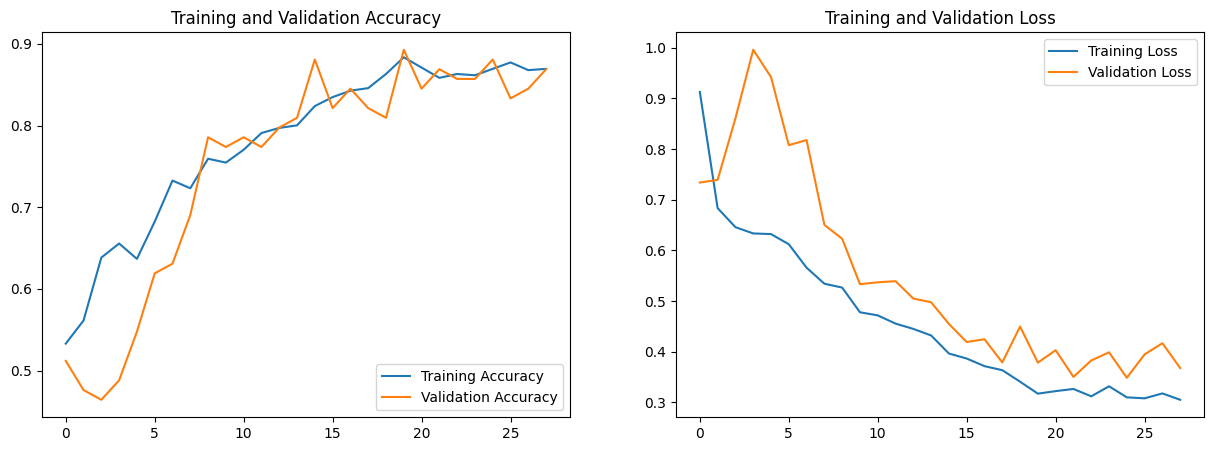

In [5]:
import matplotlib.pyplot as plt
import os

# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

# Accuracy Chart
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Chart
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# --- SAVE LOGIC --
# This ensures it saves in the same folder as your model.ipynb
filename = "accuracy_graph_2.png"
save_path = os.path.join(os.getcwd(), filename)

plt.savefig(save_path) 
print(f"Graph successfully saved at: {save_path}")
# -----------------

plt.show()

In [6]:
import matplotlib.pyplot as plt
import os

def save_accuracy_plot(history, filename="accuracy_graph_2.png"):
    # Specify the folder name
    folder = "DATASET"
    
    # Create the full path (e.g., 'DATASET/accuracy_graph_2.png')
    # Using os.path.join is best practice for cross-platform compatibility
    save_path = os.path.join(folder, filename)
    
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Save to the specific folder path
    plt.savefig(save_path) 
    plt.show()
    plt.close() # Clean up memory

In [7]:
# Load Test Data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Evaluate
print("\nRunning Final Test...")
results = model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {results[1]*100:.2f}%")

Found 85 images belonging to 2 classes.



Running Final Test...
2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9375 - loss: 0.2072

2026-02-03 06:01:48.779149: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[21,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-02-03 06:01:48.907128: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[21,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8471 - loss: 0.3328

Final Test Accuracy: 84.71%


Found 4 images. Creating grid...



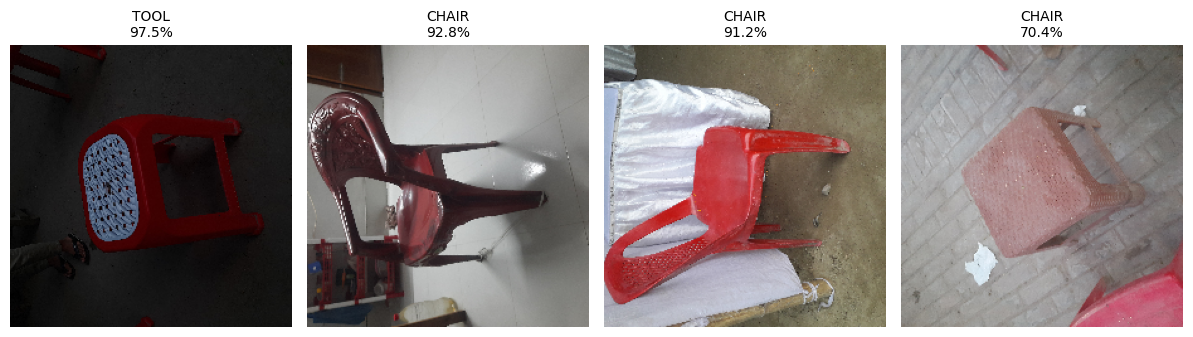

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import math

# 1. Define path - TRY AN ABSOLUTE PATH IF THIS FAILS
# Example: 'C:/Users/Name/Documents/DATASET/final'
final_folder_path = r'final' 

# Safety Check: Does the folder actually exist?
if not os.path.exists(final_folder_path):
    print(f"ERROR: The path '{final_folder_path}' does not exist.")
    print(f"Current Working Directory: {os.getcwd()}")
else:
    # 2. Get Labels automatically 
    # Adding a fallback in case train_generator isn't in memory
    try:
        labels = {value: key for key, value in train_generator.class_indices.items()}
    except NameError:
        print("Warning: 'train_generator' not found. Using default labels [0, 1].")
        labels = {0: "Class_0", 1: "Class_1"}

    # 3. Get all valid image files
    files = [f for f in os.listdir(final_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(files)

    if num_images == 0:
        print(f"No images found in: {os.path.abspath(final_folder_path)}")
    else:
        print(f"Found {num_images} images. Creating grid...\n")

        cols = 5
        rows = math.ceil(num_images / cols)

        plt.figure(figsize=(15, 3.5 * rows))

        for i, filename in enumerate(files):
            img_path = os.path.join(final_folder_path, filename)
            
            # Use target_size matching your model's input
            img = image.load_img(img_path, target_size=(224, 224))
            
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0

            # Prediction
            try:
                prediction = model.predict(img_array, verbose=0)
                score = prediction[0][0]
                
                # Binary Classification logic
                if score > 0.5:
                    label = labels[1]
                    confidence = score * 100
                else:
                    label = labels[0]
                    confidence = (1 - score) * 100
            except NameError:
                label, confidence = "No Model", 0.0

            # Plotting
            plt.subplot(rows, cols, i + 1) 
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{label.upper()}\n{confidence:.1f}%", fontsize=10)

        plt.tight_layout()
        plt.show()